In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [223]:
lookup = pd.read_csv("taxi_zone_lookup.csv")
lookup = lookup.rename(columns={'LocationID':'PULocationID'})
lookup.head()

,PULocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


TODO: append the above info by locationID to our data
then, handle others by adding them to a cumulative string.

Maybe not have a region for others? We should use a map to show final conclusions.

In [224]:
df = pd.read_parquet("tripdata_combined.parquet")
df = pd.merge(df, lookup, on='PULocationID', how="inner")
print(df.head().to_markdown())

|    |   VendorID | tpep_pickup_datetime   | tpep_dropoff_datetime   |   passenger_count |   trip_distance |   RatecodeID | store_and_fwd_flag   |   PULocationID |   DOLocationID |   payment_type |   fare_amount |   extra |   mta_tax |   tip_amount |   tolls_amount |   improvement_surcharge |   total_amount |   congestion_surcharge |   airport_fee |   Airport_fee | Borough   | Zone                          | service_zone   |
|---:|-----------:|:-----------------------|:------------------------|------------------:|----------------:|-------------:|:---------------------|---------------:|---------------:|---------------:|--------------:|--------:|----------:|-------------:|---------------:|------------------------:|---------------:|-----------------------:|--------------:|--------------:|:----------|:------------------------------|:---------------|
|  0 |          2 | 2023-01-29 17:52:02    | 2023-01-29 17:56:43     |                 1 |            1.17 |            1 | N                 

In [225]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23000000 entries, 0 to 22999999
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee         

# Research Question

RQ1: How do time, location, and trip characteristics influence the likelihood of passengers tipping?

RQ2: How do different trip features (time, distance, fare, location) influence tipping behavior?

**RQ3: Based on tipping and demand patterns, what trip lengths are most profitable across different regions?**
- We will be using tipping patterns to determine what trip lengths are most profitable across different regions.

1. Split data based on region.
2. Examine profitability-to-distance of each region.
3. Present results using graphs, hypotheses tests, or any other suitable method.

In [226]:
print(df['PULocationID'].value_counts())

PULocationID
132    1165202
161    1068300
237    1067381
236     956605
162     804190
        ...   
204         14
199         14
176         14
105          7
99           5
Name: count, Length: 262, dtype: int64


### Consider region 132. We will apply techniques to this region, and expand them to other regions.

In [227]:
df_132 = df[df['PULocationID'] == 132][['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']]
print(df_132.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1165202 entries, 12 to 22999980
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tip_amount     1165202 non-null  float64
 1   trip_distance  1165202 non-null  float64
 2   PULocationID   1165202 non-null  int64  
 3   DOLocationID   1165202 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 44.4 MB
None


Count outliers and non-null values in our data.

In [228]:
print("Number of missing values in relevant columns:")
print(df_132[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isna().sum())
print(df_132[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isnull().sum())

Number of missing values in relevant columns:
tip_amount       0
trip_distance    0
PULocationID     0
DOLocationID     0
dtype: int64
tip_amount       0
trip_distance    0
PULocationID     0
DOLocationID     0
dtype: int64


Found 3194 outliers in 'tip_amount' - comprises 0.27% of the data.


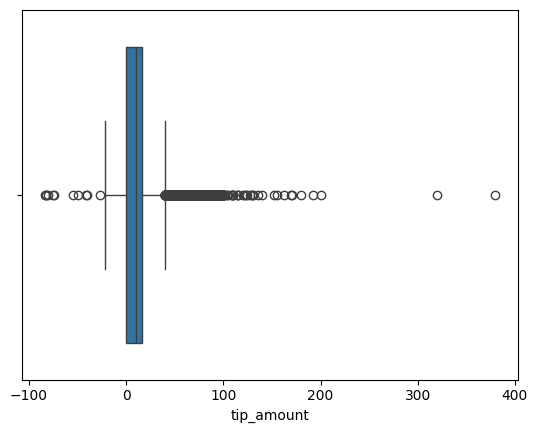

In [229]:
q1, q3 = df_132['tip_amount'].describe()['25%'], df_132['tip_amount'].describe()['75%']
iqr = q3 - q1
outliers = len(df_132[(df_132['tip_amount'] < q1 - 1.5*iqr) | (df_132['tip_amount'] > q3 + 1.5*iqr)])
print(f"Found {outliers} outliers in 'tip_amount' - comprises {(outliers / len(df_132) * 100):.2f}% of the data.")

sns.boxplot(x=df_132['tip_amount'])
plt.show()


Found 59377 outliers in 'trip_distance' - comprises 5.10% of the data.


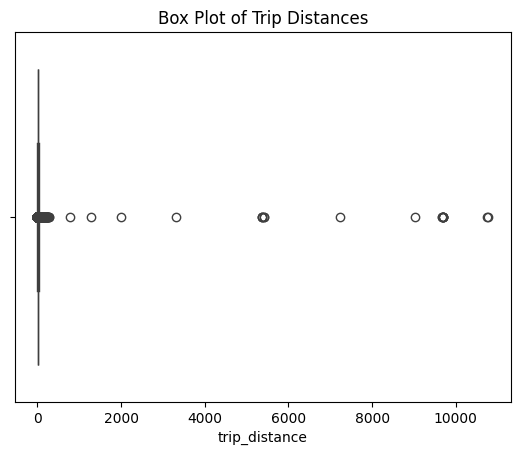

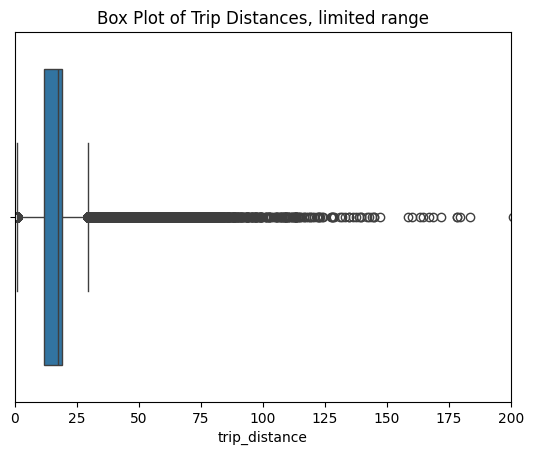

In [230]:
q1, q3 = df_132['trip_distance'].describe()['25%'], df_132['trip_distance'].describe()['75%']
iqr = q3 - q1
outliers = len(df_132[(df_132['trip_distance'] < q1 - 1.5*iqr) | (df_132['trip_distance'] > q3 + 1.5*iqr)])
print(f"Found {outliers} outliers in 'trip_distance' - comprises {(outliers / len(df_132) * 100):.2f}% of the data.")

sns.boxplot(x=df_132['trip_distance'])
plt.title("Box Plot of Trip Distances")
plt.show()

plt.title("Box Plot of Trip Distances, limited range")
sns.boxplot(x=df_132['trip_distance'])
plt.xlim(left=0, right=200)
plt.show()

From above, it seems most trips are between 0 and 200 miles. 

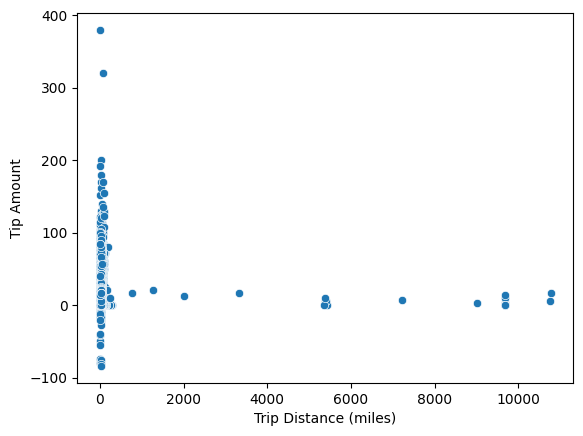

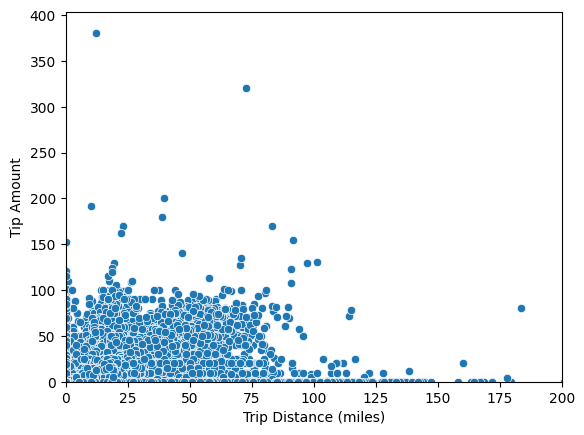

In [231]:
sns.scatterplot(data=df_132, x='trip_distance', y='tip_amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount')
plt.show()

# Remove outliers
sns.scatterplot(data=df_132, x='trip_distance', y='tip_amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount')
plt.xlim(left=0, right=200)
plt.ylim(bottom=0)
plt.show()

In the above graph, we notice a large cluster between trips that were 0-40 miles with tips that were tipped $0-$20.
We will investigate this further below.

We define short trips as trips less than 5 miles, medium trips as 5 to 20 miles, and long trips as 20+ miles.

In [232]:
bins = [0, 5, 20, float('inf')]
labels = ['short', 'medium', 'long']
df_132['trip_bin'] = pd.cut(df_132['trip_distance'], bins=bins, labels=labels)

print(df_132['trip_bin'].unique())

['medium', 'long', NaN, 'short']
Categories (3, object): ['short' < 'medium' < 'long']


Tips per Trip Calculation:

For bin short :
Mean tip: 2.143029508196722, median tip: 0.0, mode tip: 0.0
Skew: 4.380465493171194
Values are too skewed.


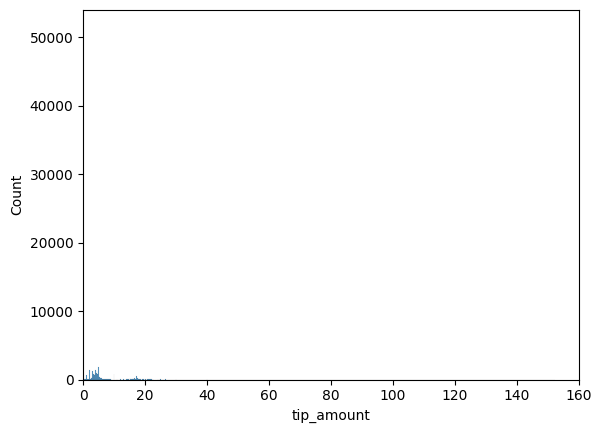

For bin medium :
Mean tip: 8.889484619995866, median tip: 10.0, mode tip: 0.0
Skew: 0.5939386544065538


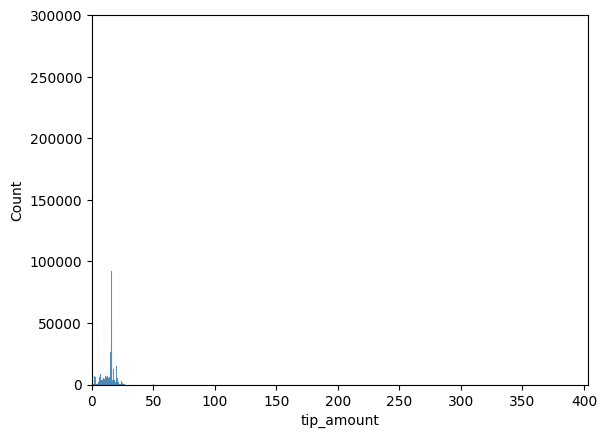

For bin long :
Mean tip: 11.832670159420045, median tip: 14.8, mode tip: 0.0
Skew: 1.5144460117919414
Values are too skewed.


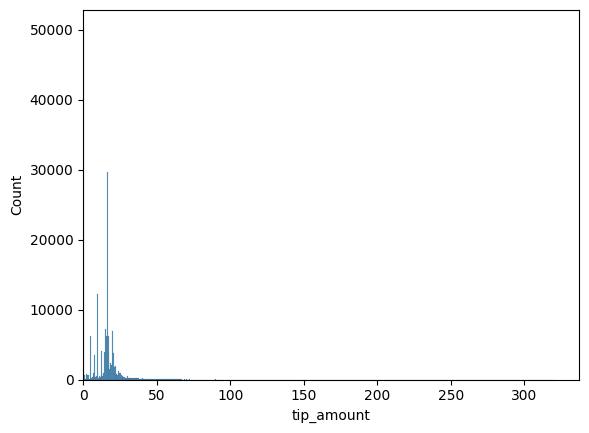

In [233]:
from scipy.stats import skew

for bin in ['short', 'medium', 'long']:
    print("For bin", bin, ":")
    tip_bin = df_132[df_132['trip_bin'] == bin]['tip_amount']
    print(f"Mean tip: {tip_bin.mean()}, median tip: {tip_bin.median()}, mode tip: {tip_bin.mode()[0]}")
    # print(f"Median tip, discarding zeros: {tip_bin[tip_bin > 0].median()}, mode tip, discarding zeros: {tip_bin[tip_bin > 0].mode()[0]}")
    skew_val = skew(tip_bin)
    print("Skew:", skew_val)
    if skew_val < -1 or skew_val > 1:
        print("Values are too skewed.")

    sns.histplot(data=tip_bin)
    plt.xlim(left=0)
    plt.show()

From above, we can determine long trips are the most profitable based on mean and median.

Evaluating Frequency and Demand Patterns

In [234]:
df_132['trip_bin'].value_counts()

trip_bin
medium    885793
long      178083
short      76250
Name: count, dtype: int64

From above, we can determine medium-length trips are in high demand, followed by long trips, then short trips. 

In [235]:
max_tip, max_bin = 0, "None"

for bin in ['short', 'medium', 'long']:
    tip_bin = df_132[df_132['trip_bin'] == bin]['tip_amount']
    expected_tip = tip_bin.mean() * (len(tip_bin) / len(df_132['trip_bin']))
    print(f"Expected average tip for {bin} trips: {expected_tip:.2f}")
    if expected_tip > max_tip:
        max_bin = bin
        max_tip = expected_tip

print(f"For region 132, the taxi company should prioritize {max_bin} trips, for an average expected tip of ${max_tip:.2f}.")

Expected average tip for short trips: 0.14
Expected average tip for medium trips: 6.76
Expected average tip for long trips: 1.81
For region 132, the taxi company should prioritize medium trips, for an average expected tip of $6.76.


Assert the above using a hypothesis test.


Since we will be analyzing if there are 3 groups, each sampled from 3 non-normal distributions, we will apply the Kruskal-Wallis H-test, with $\alpha=0.05$.

Statistic values match those of the chi-squared test but with 1 less D.O.F. The relevant chi-squared value for 3 groups (D.O.F.=3) and $\alpha=0.05$ is 5.991 ([source](https://www.scribbr.com/statistics/chi-square-distribution-table/)) - the value for significance $\alpha-0.05$ and D.O.F. = 2.

In [236]:
from scipy.stats import kruskal

samples = [df_132[df_132['trip_bin'] == bin]['tip_amount'].sample(n=30, random_state=42).to_list() for bin in ['short', 'medium', 'long']]
result = kruskal(*samples)
print(result)
print(result.statistic, result.pvalue)

if result.pvalue < 0.05:
    print("Reject the null hypothesis - there is significant difference between the groups.")
    if result.statistic > 5.991:
        print("Results are statistically significant.")
else:
    print("Failed to reject null hypothesis.")

KruskalResult(statistic=np.float64(21.252226593656722), pvalue=np.float64(2.427379227496243e-05))
21.252226593656722 2.427379227496243e-05
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.


Repeat this for all regions.

# Calculate best trip for each region.

Note that this involves running hypothesis tests within each region, not across all regions.

In [237]:
from scipy.stats import skew, kruskal

other_regions = []

def analyze_region(reg_id:int, bins = [0, 5, 20, float('inf')], min_entries=15, verbose=False)->int:
    """
        Given the ID of a region (and optionally the bins for the trip distances), 
        perform the above analysis and return what length of trip gives the best tips 
        as well as its H-value and its significance.
    """

    if verbose: print(f"Examining region {reg_id}")
    df_region = df[df['PULocationID'] == reg_id][['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']]
    
    if verbose: 
        print(df_region.info())
        print("----------------------------")

        print(f"Number of missing values in relevant columns for region {reg_id}:")
        print(df_region[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isna().sum())
        print(df_region[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isnull().sum())
        print("----------------------------")
    
    q1, q3 = df_region['tip_amount'].describe()['25%'], df_region['tip_amount'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['tip_amount'] < q1 - 1.5*iqr) | (df_region['tip_amount'] > q3 + 1.5*iqr)])
    
    if verbose: 
        print(f"Found {outliers} outliers in 'tip_amount' - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['tip_amount'])
        plt.title(f'Boxplot for tipping amount in region {reg_id}')
        plt.show()
        print("----------------------------")

    q1, q3 = df_region['trip_distance'].describe()['25%'], df_region['trip_distance'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['trip_distance'] < q1 - 1.5*iqr) | (df_region['trip_distance'] > q3 + 1.5*iqr)])

    if verbose: 
        print(f"Found {outliers} outliers in 'trip_distance' for {reg_id} - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['trip_distance'])
        plt.title(f"Box Plot of Trip Distances in region {reg_id}")
        plt.show()

        plt.title(f"Box Plot of Trip Distances, limited range, in region {reg_id}")
        sns.boxplot(x=df_region['trip_distance'])
        plt.xlim(left=0, right=200)
        plt.show()
        print("----------------------------")

        sns.scatterplot(data=df_region, x='trip_distance', y='tip_amount')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in region {reg_id}")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.show()

        # Remove outliers
        sns.scatterplot(data=df_region, x='trip_distance', y='tip_amount')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in region {reg_id}, without outliers")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.xlim(left=0, right=200)
        plt.ylim(bottom=0)
        plt.show()    
        print("----------------------------")

    labels = ['short', 'medium', 'long']
    df_region['trip_bin'] = pd.cut(df_region['trip_distance'], bins=bins, labels=labels)

    for bin in ['short', 'medium', 'long']:
        if verbose: print("For bin", bin, ":")
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_amount']
        if verbose: print(f"Mean tip: {tip_bin.mean()}, median tip: {tip_bin.median()}, mode tip: {tip_bin.mode()[0]}")
        # print(f"Median tip, discarding zeros: {tip_bin[tip_bin > 0].median()}, mode tip, discarding zeros: {tip_bin[tip_bin > 0].mode()[0]}")
        
        if len(tip_bin) >= min_entries:
            skew_val = skew(tip_bin)
            if verbose: print("Skew:", skew_val)
            if skew_val < -1 or skew_val > 1:
                if verbose: print("Values are too skewed.")

        if verbose: 
            sns.histplot(data=tip_bin)
            plt.xlim(left=0)
            plt.show()

    if verbose: 
        print(f"Value count of each trip type in each region:\n{df_region['trip_bin'].value_counts()}")

        print("----------------------------")

    max_tip, max_bin = None, None
    tips = []

    for bin in ['short', 'medium', 'long']:
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_amount']
        expected_tip = tip_bin.mean() * (len(tip_bin) / len(df_region['trip_bin']))
        # expected_tip = tip_bin.mean()
        tips.append(expected_tip)
        if verbose: print(f"Expected average tip for {bin} trips: {expected_tip:.2f}")
        if not max_tip or expected_tip > max_tip:
            max_bin = bin
            max_tip = expected_tip

    print(f"For region {reg_id}, the taxi company should prioritize {max_bin} trips, for an average expected tip of ${max_tip:.2f}.")
    print("----------------------------")

    # Check if we have 30 points to sample.
    # If not, sample as much as we can.
    result = None

    try:
        bottleneck = min([len(df_region[df_region['trip_bin'] == bin]) for bin in ['short', 'medium', 'long']])
        if bottleneck >= min_entries:
            sample_number = min(bottleneck, 30)
            print(f"Sampling {sample_number} entries.")
            samples = [df_region[df_region['trip_bin'] == bin]['tip_amount'].sample(n=sample_number, random_state=42).to_list() for bin in ['short', 'medium', 'long']]
            
            result = kruskal(*samples)
            print(result)
            if verbose: print(result.statistic, result.pvalue)

            if result.pvalue < 0.05:
                print("Reject the null hypothesis - there is significant difference between the groups.")
                if result.statistic > 5.991:
                    print("Results are statistically significant.")
            else:
                print("Failed to reject null hypothesis.")
            print("----------------------------")

        else:
            print(f"Could not run hypothesis test on region {reg_id}")
            other_regions.append(reg_id)
    except ValueError:
        print(f"Could not run hypothesis test on region {reg_id}")
        other_regions.append(reg_id)

    return {
        'region_id':reg_id,
        'short_tip':tips[0],
        'med_tip':tips[1],
        'long_tip':tips[2],
        'max_tip':max_tip,
        'max_bin':max_bin,
        'is_statistically_significant':result.pvalue < 0.05 if result else None,
        'has_rejected_null_hyp':result.statistic > 5.991 if result else None
    }

In [238]:
locations = df['PULocationID'].unique()
results = []
for id in locations:
    # results.append(analyze_region(id, min_entries=1))
    results.append(analyze_region(id))

For region 262, the taxi company should prioritize short trips, for an average expected tip of $2.11.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(23.528005079046178), pvalue=np.float64(7.779624081434098e-06))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 229, the taxi company should prioritize short trips, for an average expected tip of $2.26.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(24.933717126168087), pvalue=np.float64(3.852229204456514e-06))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 45, the taxi company should prioritize short trips, for an average expected tip of $1.79.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(5.83680577374464

In [239]:
# results.append(handle_others()) # Skip invalid regions due to invalid data

In [240]:
results_df = pd.DataFrame(results)

results_df = pd.merge(
    results_df, 
    lookup, 
    left_on='region_id', 
    right_on='PULocationID',
    how='left'    
)
print(results_df.isna().sum())
print(len(results_df))

region_id                        0
short_tip                        0
med_tip                          1
long_tip                         3
max_tip                          0
max_bin                          0
is_statistically_significant    79
has_rejected_null_hyp           79
PULocationID                     0
Borough                          1
Zone                             1
service_zone                     2
dtype: int64
262


In [241]:
res_df = results_df.dropna()
print(len(res_df))

181


In [242]:
res_df.to_csv("analysis_data.csv", index=False)

# Read and Graph Data

In [243]:
res_df = pd.read_csv('analysis_data.csv')
res_df['color'] = res_df['max_bin'].map({
    'short':'red',
    'medium':'green',
    'long':'blue',
})
res_df.head()

,region_id,short_tip,med_tip,long_tip,max_tip,max_bin,is_statistically_significant,has_rejected_null_hyp,PULocationID,Borough,Zone,service_zone,color
0,262,2.108692,0.568971,0.019880,2.108692,short,True,True,262,Manhattan,Yorkville East,Yellow Zone,red
1,229,2.261935,0.434956,0.019613,2.261935,short,True,True,229,Manhattan,Sutton Place/Turtle Bay North,Yellow Zone,red
2,45,1.788041,1.026782,0.023839,1.788041,short,False,False,45,Manhattan,Chinatown,Yellow Zone,red
3,237,2.305779,0.298140,0.015927,2.305779,short,True,True,237,Manhattan,Upper East Side South,Yellow Zone,red
4,137,2.055876,0.400888,0.007302,2.055876,short,False,False,137,Manhattan,Kips Bay,Yellow Zone,red


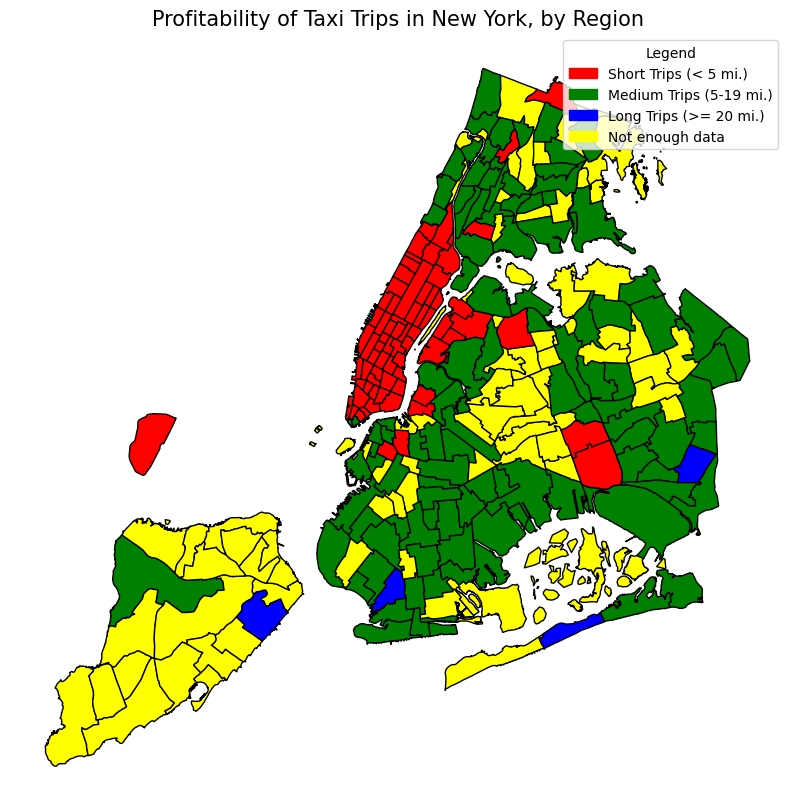

In [244]:
import geopandas as gpd
from matplotlib.patches import Patch

gdf = gpd.read_file('./taxi_zones/taxi_zones.shp')
color_mapping_df = res_df[['region_id', 'color']]

gdf = gdf.merge(color_mapping_df, how='left', left_on='LocationID', right_on='region_id')
gdf['color'] = gdf['color'].fillna('yellow')

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black')

legend_handles = [
    Patch(color='red', label=f'Short Trips (< 5 mi.)'),
    Patch(color='green', label=f'Medium Trips (5-19 mi.)'),
    Patch(color='blue', label=f'Long Trips (>= 20 mi.)'),
    Patch(color='yellow', label=f'Not enough data')
]

ax.legend(handles=legend_handles, title='Legend', loc='upper right')

ax.set_title("Profitability of Taxi Trips in New York, by Region", fontsize=15)
ax.set_axis_off()  # Hide the axis

# Show the plot
plt.show()

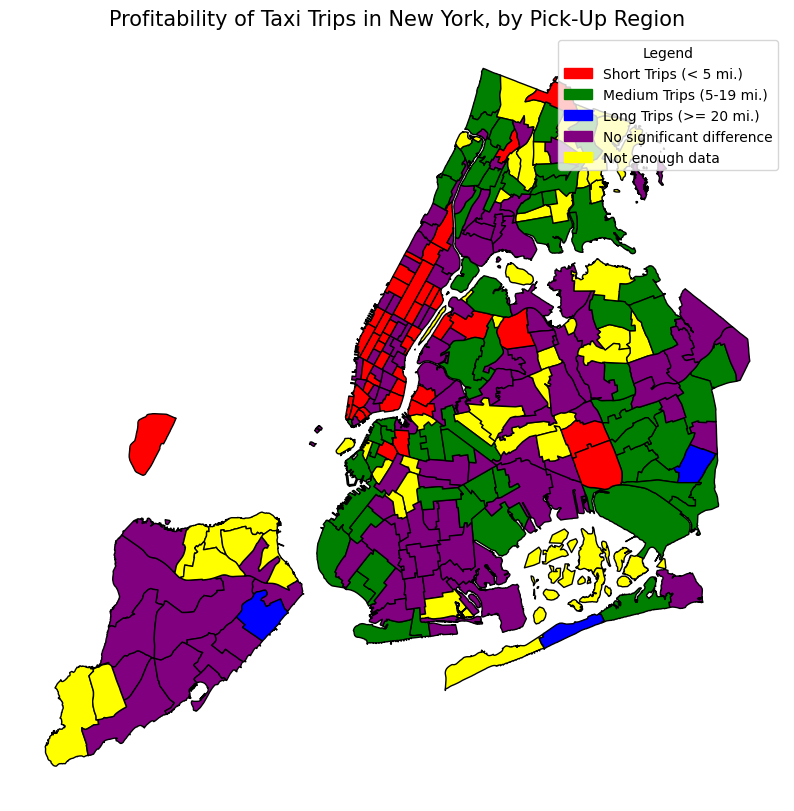

In [245]:

gdf['is_statistically_significant'] = res_df['is_statistically_significant']
gdf.loc[gdf['is_statistically_significant'] == False, 'color'] = 'purple'

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black')

legend_handles = [
    Patch(color='red', label=f'Short Trips (< 5 mi.)'),
    Patch(color='green', label=f'Medium Trips (5-19 mi.)'),
    Patch(color='blue', label=f'Long Trips (>= 20 mi.)'),
    Patch(color='purple', label=f'No significant difference'),
    Patch(color='yellow', label=f'Not enough data')
]

ax.legend(handles=legend_handles, title='Legend', loc='upper right')

ax.set_title("Profitability of Taxi Trips in New York, by Pick-Up Region", fontsize=15)
ax.set_axis_off()  # Hide the axis

# Show the plot
plt.show()

In [246]:
print(res_df['max_bin'].value_counts())

max_bin
medium    106
short      71
long        4
Name: count, dtype: int64


# Repeat the above but for drop-off locations.

In [247]:
from scipy.stats import skew, kruskal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

other_regions = []

def do_analyze_region(reg_id:int, bins = [0, 5, 20, float('inf')], min_entries=15, verbose=False)->int:
    """
        Given the ID of a region (and optionally the bins for the trip distances), 
        perform the above analysis and return what length of trip gives the best tips 
        as well as its H-value and its significance.
    """

    if verbose: print(f"Examining region {reg_id}")
    df_region = df[df['DOLocationID'] == reg_id][['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']]
    
    if verbose: 
        print(df_region.info())
        print("----------------------------")

        print(f"Number of missing values in relevant columns for region {reg_id}:")
        print(df_region[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isna().sum())
        print(df_region[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isnull().sum())
        print("----------------------------")
    
    q1, q3 = df_region['tip_amount'].describe()['25%'], df_region['tip_amount'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['tip_amount'] < q1 - 1.5*iqr) | (df_region['tip_amount'] > q3 + 1.5*iqr)])
    
    if verbose: 
        print(f"Found {outliers} outliers in 'tip_amount' - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['tip_amount'])
        plt.title(f'Boxplot for tipping amount in region {reg_id}')
        plt.show()
        print("----------------------------")

    q1, q3 = df_region['trip_distance'].describe()['25%'], df_region['trip_distance'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['trip_distance'] < q1 - 1.5*iqr) | (df_region['trip_distance'] > q3 + 1.5*iqr)])

    if verbose: 
        print(f"Found {outliers} outliers in 'trip_distance' for {reg_id} - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['trip_distance'])
        plt.title(f"Box Plot of Trip Distances in region {reg_id}")
        plt.show()

        plt.title(f"Box Plot of Trip Distances, limited range, in region {reg_id}")
        sns.boxplot(x=df_region['trip_distance'])
        plt.xlim(left=0, right=200)
        plt.show()
        print("----------------------------")

        sns.scatterplot(data=df_region, x='trip_distance', y='tip_amount')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in region {reg_id}")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.show()

        # Remove outliers
        sns.scatterplot(data=df_region, x='trip_distance', y='tip_amount')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in region {reg_id}, without outliers")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.xlim(left=0, right=200)
        plt.ylim(bottom=0)
        plt.show()    
        print("----------------------------")

    labels = ['short', 'medium', 'long']
    df_region['trip_bin'] = pd.cut(df_region['trip_distance'], bins=bins, labels=labels)

    for bin in ['short', 'medium', 'long']:
        if verbose: print("For bin", bin, ":")
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_amount']
        if verbose: print(f"Mean tip: {tip_bin.mean()}, median tip: {tip_bin.median()}, mode tip: {tip_bin.mode()[0]}")
        # print(f"Median tip, discarding zeros: {tip_bin[tip_bin > 0].median()}, mode tip, discarding zeros: {tip_bin[tip_bin > 0].mode()[0]}")
        
        if len(tip_bin) >= min_entries:
            skew_val = skew(tip_bin)
            if verbose: print("Skew:", skew_val)
            if skew_val < -1 or skew_val > 1:
                if verbose: print("Values are too skewed.")

        if verbose: 
            sns.histplot(data=tip_bin)
            plt.xlim(left=0)
            plt.show()

    if verbose: 
        print(f"Value count of each trip type in each region:\n{df_region['trip_bin'].value_counts()}")

        print("----------------------------")

    max_tip, max_bin = None, None
    tips = []

    for bin in ['short', 'medium', 'long']:
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_amount']
        expected_tip = tip_bin.mean() * (len(tip_bin) / len(df_region['trip_bin']))
        # expected_tip = tip_bin.mean()
        tips.append(expected_tip)
        if verbose: print(f"Expected average tip for {bin} trips: {expected_tip:.2f}")
        if not max_tip or expected_tip > max_tip:
            max_bin = bin
            max_tip = expected_tip

    print(f"For region {reg_id}, the taxi company should prioritize {max_bin} trips, for an average expected tip of ${max_tip:.2f}.")
    print("----------------------------")

    # Check if we have 30 points to sample.
    # If not, sample as much as we can.
    result = None

    try:
        bottleneck = min([len(df_region[df_region['trip_bin'] == bin]) for bin in ['short', 'medium', 'long']])
        if bottleneck >= min_entries:
            sample_number = min(bottleneck, 30)
            print(f"Sampling {sample_number} entries.")
            samples = [df_region[df_region['trip_bin'] == bin]['tip_amount'].sample(n=sample_number, random_state=42).to_list() for bin in ['short', 'medium', 'long']]
            
            result = kruskal(*samples)
            print(result)
            if verbose: print(result.statistic, result.pvalue)

            if result.pvalue < 0.05:
                print("Reject the null hypothesis - there is significant difference between the groups.")
                if result.statistic > 5.991:
                    print("Results are statistically significant.")
            else:
                print("Failed to reject null hypothesis.")
            print("----------------------------")

        else:
            print(f"Could not run hypothesis test on region {reg_id}")
            other_regions.append(reg_id)
    except ValueError:
        print(f"Could not run hypothesis test on region {reg_id}")
        other_regions.append(reg_id)

    return {
        'do_region_id':reg_id,
        'short_tip':tips[0],
        'med_tip':tips[1],
        'long_tip':tips[2],
        'max_tip':max_tip,
        'max_bin':max_bin,
        'is_statistically_significant':result.pvalue < 0.05 if result else None,
        'has_rejected_null_hyp':result.statistic > 5.991 if result else None
    }

In [248]:
lookup = pd.read_csv("taxi_zone_lookup.csv")
lookup = lookup.rename(columns={'LocationID':'DOLocationID'})
lookup.head()

,DOLocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [249]:
df = pd.read_parquet("tripdata_combined.parquet")
df = pd.merge(df, lookup, on='DOLocationID' ,how="inner")
print(df.head().to_markdown())

|    |   VendorID | tpep_pickup_datetime   | tpep_dropoff_datetime   |   passenger_count |   trip_distance |   RatecodeID | store_and_fwd_flag   |   PULocationID |   DOLocationID |   payment_type |   fare_amount |   extra |   mta_tax |   tip_amount |   tolls_amount |   improvement_surcharge |   total_amount |   congestion_surcharge |   airport_fee |   Airport_fee | Borough   | Zone                  | service_zone   |
|---:|-----------:|:-----------------------|:------------------------|------------------:|----------------:|-------------:|:---------------------|---------------:|---------------:|---------------:|--------------:|--------:|----------:|-------------:|---------------:|------------------------:|---------------:|-----------------------:|--------------:|--------------:|:----------|:----------------------|:---------------|
|  0 |          2 | 2023-01-29 17:52:02    | 2023-01-29 17:56:43     |                 1 |            1.17 |            1 | N                    |            

In [250]:
locations = df['DOLocationID'].unique()
results = []
for id in locations:
    # results.append(analyze_region(id, min_entries=1))
    results.append(do_analyze_region(id))

For region 74, the taxi company should prioritize short trips, for an average expected tip of $1.67.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(7.090607589844046), pvalue=np.float64(0.028859853700788102))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 237, the taxi company should prioritize short trips, for an average expected tip of $2.29.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.835581840637288), pvalue=np.float64(0.032784779192060805))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 261, the taxi company should prioritize medium trips, for an average expected tip of $1.81.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(22.563209868305794)

In [251]:
results_df = pd.DataFrame(results)

results_df = pd.merge(
    results_df, 
    lookup, 
    left_on='do_region_id', 
    right_on='DOLocationID',
    how='left'    
)
print(results_df.isna().sum())
print(len(results_df))

do_region_id                     0
short_tip                        2
med_tip                          1
long_tip                         1
max_tip                          2
max_bin                          0
is_statistically_significant    33
has_rejected_null_hyp           33
DOLocationID                     0
Borough                          1
Zone                             1
service_zone                     2
dtype: int64
262


In [252]:
res_df = results_df.dropna()
print(len(res_df))

res_df.to_csv("do_analysis_data.csv", index=False)

227


In [253]:
res_df = pd.read_csv('do_analysis_data.csv')
res_df['color'] = res_df['max_bin'].map({
    'short':'red',
    'medium':'green',
    'long':'blue',
})
res_df.head()

,do_region_id,short_tip,med_tip,long_tip,max_tip,max_bin,is_statistically_significant,has_rejected_null_hyp,DOLocationID,Borough,Zone,service_zone,color
0,74,1.670416,0.739581,0.006425,1.670416,short,True,True,74,Manhattan,East Harlem North,Boro Zone,red
1,237,2.287626,0.314896,0.039710,2.287626,short,True,True,237,Manhattan,Upper East Side South,Yellow Zone,red
2,261,1.694201,1.812991,0.661667,1.812991,medium,True,True,261,Manhattan,World Trade Center,Yellow Zone,green
3,141,2.263706,0.483428,0.066713,2.263706,short,True,True,141,Manhattan,Lenox Hill West,Yellow Zone,red
4,140,2.331002,0.444357,0.065786,2.331002,short,True,True,140,Manhattan,Lenox Hill East,Yellow Zone,red


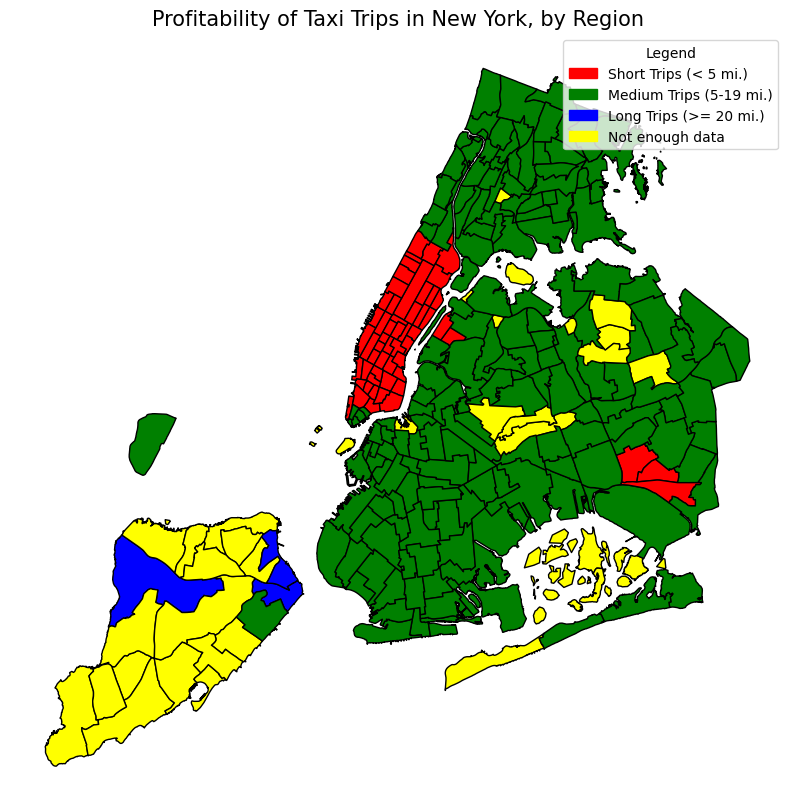

In [254]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load the shapefile
gdf = gpd.read_file('./taxi_zones/taxi_zones.shp')

# Merge with the color mapping dataframe
color_mapping_df = res_df[['do_region_id', 'color']]
gdf = gdf.merge(color_mapping_df, how='left', left_on='LocationID', right_on='do_region_id')
gdf['color'] = gdf['color'].fillna('yellow')

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black')

# Add legend
legend_handles = [
    Patch(color='red', label=f'Short Trips (< 5 mi.)'),
    Patch(color='green', label=f'Medium Trips (5-19 mi.)'),
    Patch(color='blue', label=f'Long Trips (>= 20 mi.)'),
    Patch(color='yellow', label=f'Not enough data')
]

ax.legend(handles=legend_handles, title='Legend', loc='upper right')

# Set title and hide axis
ax.set_title("Profitability of Taxi Trips in New York, by Region", fontsize=15)
ax.set_axis_off()  # Hide the axis

# Show the plot
plt.show()

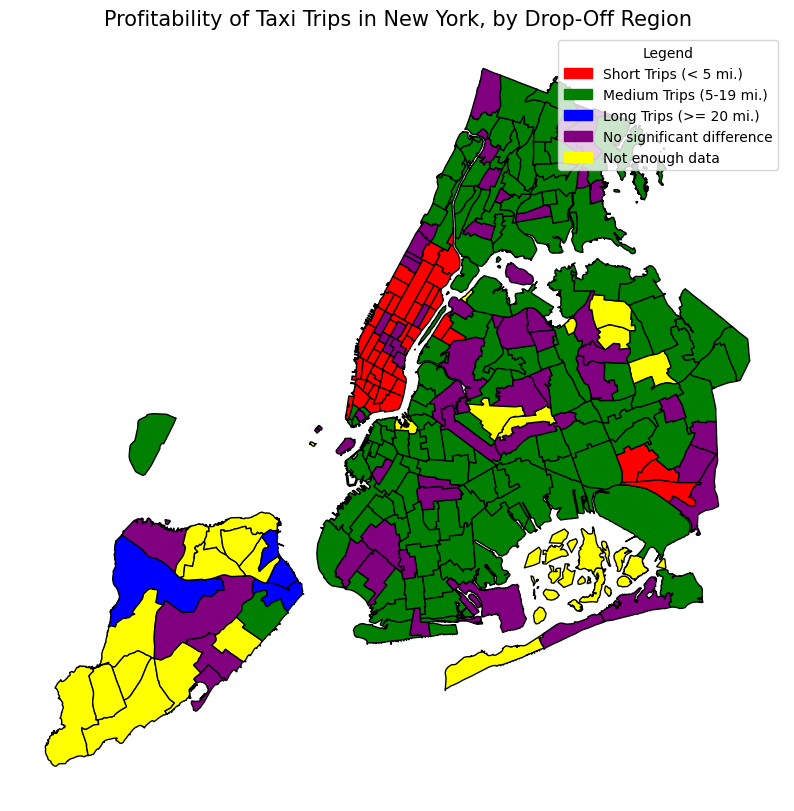

In [255]:

gdf['is_statistically_significant'] = res_df['is_statistically_significant']
gdf.loc[gdf['is_statistically_significant'] == False, 'color'] = 'purple'

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black')

legend_handles = [
    Patch(color='red', label=f'Short Trips (< 5 mi.)'),
    Patch(color='green', label=f'Medium Trips (5-19 mi.)'),
    Patch(color='blue', label=f'Long Trips (>= 20 mi.)'),
    Patch(color='purple', label=f'No significant difference'),
    Patch(color='yellow', label=f'Not enough data')
]

ax.legend(handles=legend_handles, title='Legend', loc='upper right')

# Add borough names
boroughs = {
    'Staten Island': (-74.15, 40.58),
    'Manhattan': (-73.97, 40.78),
    'Bronx': (-73.87, 40.85),
    'Brooklyn': (-73.95, 40.65),
    'Queens': (-73.82, 40.75)
}

for borough, (x, y) in boroughs.items():
    ax.annotate(
        borough,
        xy=(x, y),
        xytext=(x, y),
        fontsize=12,
        color='white',
        weight='bold',
        ha='center',
        va='center',
        bbox=dict(facecolor='grey', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
    )


ax.set_title("Profitability of Taxi Trips in New York, by Drop-Off Region", fontsize=15)
ax.set_axis_off()  # Hide the axis

# Show the plot
plt.show()

# Repeat the above, but based on tip_amount / fare_amount (% extra)

### First, analyze based on pick-up regions.

In [256]:
from scipy.stats import skew, kruskal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

other_regions = []

def percent_analyze_region(reg_id:int, bins = [0, 5, 20, float('inf')], min_entries=15, verbose=False)->int:
    """
        Given the ID of a region (and optionally the bins for the trip distances), 
        perform the above analysis and return what length of trip gives the best tips 
        as well as its H-value and its significance.
    """

    if verbose: print(f"Examining region {reg_id}")
    df_region = df[df['PULocationID'] == reg_id][['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount']]
    df_region['tip_percent'] = df_region['tip_amount'] / df_region['fare_amount']
    
    if verbose: 
        print(df_region.info())
        print("----------------------------")

        print(f"Number of missing values in relevant columns for region {reg_id}:")
        print(df_region[['tip_percent', 'trip_distance', 'PULocationID', 'DOLocationID']].isna().sum())
        print(df_region[['tip_percent', 'trip_distance', 'PULocationID', 'DOLocationID']].isnull().sum())
        print("----------------------------")
    
    q1, q3 = df_region['tip_percent'].describe()['25%'], df_region['tip_percent'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['tip_percent'] < q1 - 1.5*iqr) | (df_region['tip_percent'] > q3 + 1.5*iqr)])
    
    if verbose: 
        print(f"Found {outliers} outliers in 'tip_amount' - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['tip_amount'])
        plt.title(f'Boxplot for tipping amount in region {reg_id}')
        plt.show()
        print("----------------------------")

    q1, q3 = df_region['trip_distance'].describe()['25%'], df_region['trip_distance'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['trip_distance'] < q1 - 1.5*iqr) | (df_region['trip_distance'] > q3 + 1.5*iqr)])

    if verbose: 
        print(f"Found {outliers} outliers in 'trip_distance' for {reg_id} - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['trip_distance'])
        plt.title(f"Box Plot of Trip Distances in region {reg_id}")
        plt.show()

        plt.title(f"Box Plot of Trip Distances, limited range, in region {reg_id}")
        sns.boxplot(x=df_region['trip_distance'])
        plt.xlim(left=0, right=200)
        plt.show()
        print("----------------------------")

        sns.scatterplot(data=df_region, x='trip_distance', y='tip_percent')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in region {reg_id}")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.show()

        # Remove outliers
        sns.scatterplot(data=df_region, x='trip_distance', y='tip_percent')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in region {reg_id}, without outliers")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.xlim(left=0, right=200)
        plt.ylim(bottom=0)
        plt.show()    
        print("----------------------------")

    labels = ['short', 'medium', 'long']
    df_region['trip_bin'] = pd.cut(df_region['trip_distance'], bins=bins, labels=labels)

    for bin in ['short', 'medium', 'long']:
        if verbose: print("For bin", bin, ":")
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_percent']
        if verbose: print(f"Mean tip: {tip_bin.mean()}, median tip: {tip_bin.median()}, mode tip: {tip_bin.mode()[0]}")
        # print(f"Median tip, discarding zeros: {tip_bin[tip_bin > 0].median()}, mode tip, discarding zeros: {tip_bin[tip_bin > 0].mode()[0]}")
        
        if len(tip_bin) >= min_entries:
            skew_val = skew(tip_bin)
            if verbose: print("Skew:", skew_val)
            if skew_val < -1 or skew_val > 1:
                if verbose: print("Values are too skewed.")

        if verbose: 
            sns.histplot(data=tip_bin)
            plt.xlim(left=0)
            plt.show()

    if verbose: 
        print(f"Value count of each trip type in each region:\n{df_region['trip_bin'].value_counts()}")

        print("----------------------------")

    max_tip, max_bin = None, None
    tips = []

    for bin in ['short', 'medium', 'long']:
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_percent']
        expected_tip = tip_bin.mean() 
        tips.append(expected_tip)
        if verbose: print(f"Expected average tip percent for {bin} trips: {expected_tip:.2f}")
        if not max_tip or expected_tip > max_tip:
            max_bin = bin
            max_tip = expected_tip

    print(f"For region {reg_id}, the taxi company should prioritize {max_bin} trips, for an average expected tip percent of ${max_tip:.2f}.")
    print("----------------------------")

    # Check if we have 30 points to sample.
    # If not, sample as much as we can.
    result = None

    try:
        bottleneck = min([len(df_region[df_region['trip_bin'] == bin]) for bin in ['short', 'medium', 'long']])
        if bottleneck >= min_entries:
            sample_number = min(bottleneck, 30)
            print(f"Sampling {sample_number} entries.")
            samples = [df_region[df_region['trip_bin'] == bin]['tip_percent'].sample(n=sample_number, random_state=42).to_list() for bin in ['short', 'medium', 'long']]
            
            result = kruskal(*samples)
            print(result)
            if verbose: print(result.statistic, result.pvalue)

            if result.pvalue < 0.05:
                print("Reject the null hypothesis - there is significant difference between the groups.")
                if result.statistic > 5.991:
                    print("Results are statistically significant.")
            else:
                print("Failed to reject null hypothesis.")
            print("----------------------------")

        else:
            print(f"Could not run hypothesis test on region {reg_id}")
            other_regions.append(reg_id)
    except ValueError:
        print(f"Could not run hypothesis test on region {reg_id}")
        other_regions.append(reg_id)

    return {
        'region_id':reg_id,
        'short_tip_percent':tips[0],
        'med_tip_percent':tips[1],
        'long_tip_percent':tips[2],
        'max_tip_percent':max_tip,
        'max_bin':max_bin,
        'is_statistically_significant':result.pvalue < 0.05 if result else None,
        'has_rejected_null_hyp':result.statistic > 5.991 if result else None
    }

In [257]:
lookup = pd.read_csv("taxi_zone_lookup.csv")
lookup = lookup.rename(columns={'LocationID':'PULocationID'})
lookup.head()

,PULocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [258]:
df = pd.read_parquet("tripdata_combined.parquet")
df = pd.merge(df, lookup, on='PULocationID' ,how="inner")
print(df.head().to_markdown())

|    |   VendorID | tpep_pickup_datetime   | tpep_dropoff_datetime   |   passenger_count |   trip_distance |   RatecodeID | store_and_fwd_flag   |   PULocationID |   DOLocationID |   payment_type |   fare_amount |   extra |   mta_tax |   tip_amount |   tolls_amount |   improvement_surcharge |   total_amount |   congestion_surcharge |   airport_fee |   Airport_fee | Borough   | Zone                          | service_zone   |
|---:|-----------:|:-----------------------|:------------------------|------------------:|----------------:|-------------:|:---------------------|---------------:|---------------:|---------------:|--------------:|--------:|----------:|-------------:|---------------:|------------------------:|---------------:|-----------------------:|--------------:|--------------:|:----------|:------------------------------|:---------------|
|  0 |          2 | 2023-01-29 17:52:02    | 2023-01-29 17:56:43     |                 1 |            1.17 |            1 | N                 

In [259]:
locations = df['PULocationID'].unique()
results = []
for id in locations:
    # results.append(analyze_region(id, min_entries=1))
    results.append(percent_analyze_region(id))

For region 262, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.6374592252163422), pvalue=np.float64(0.26747488293940347))
Failed to reject null hypothesis.
----------------------------
For region 229, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(16.845797175923252), pvalue=np.float64(0.00021977668661815123))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 45, the taxi company should prioritize short trips, for an average expected tip percent of $0.17.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.6594377101888538), pvalue=np.float64(0.4361718965917827))
Failed to reject nu

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 237, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.5218248378361976), pvalue=np.float64(0.7703483846056722))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1127: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


For region 137, the taxi company should prioritize long trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(12.432059095106208), pvalue=np.float64(0.0019971591212987927))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 68, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(10.854893798137686), pvalue=np.float64(0.004394300586028966))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 170, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.6218364737924635), pvalue=np.float64(0.16350393250818732))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 107, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.6697384392497607), pvalue=np.float64(0.15963437744678818))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


For region 239, the taxi company should prioritize short trips, for an average expected tip percent of $nan.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.619230769230805), pvalue=np.float64(0.44502919838709476))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 234, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(5.02265178260648), pvalue=np.float64(0.08116055779197612))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 141, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.0649005901804454), pvalue=np.float64(0.587164479344986))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 132, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.920848679277967), pvalue=np.float64(0.031416427953785665))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 24, the taxi company should prioritize short trips, for an average expected tip percent of $0.18.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.233509962971944), pvalue=np.float64(0.19854192710502191))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 140, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(8.664496392690577), pvalue=np.float64(0.01313797750995161))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 246, the taxi company should prioritize short trips, for an average expected tip percent of $0.20.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(14.42575822573638), pvalue=np.float64(0.0007370320991912738))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 162, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(11.22464720885679), pvalue=np.float64(0.0036525723564167015))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 224, the taxi company should prioritize short trips, for an average expected tip percent of $0.16.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.700272438672461), pvalue=np.float64(0.4273567137357148))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 249, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.331025320939997), pvalue=np.float64(0.18909369226770975))
Failed to reject null hypothesis.
----------------------------
For region 236, the taxi company should prioritize short trips, for an average expected tip percent of $0.22.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 87, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.061224125325808), pvalue=np.float64(0.35678851679564444))
Failed to reject null hypothesis.
----------------------------
For region 148, the taxi company should prioritize medium trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(17.476341962474113), pvalue=np.float64(0.00016034689735181174))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 142, the taxi company should prioritize short trips, for an average expected tip percent of $0.22.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.3573964497041429), pvalue=np.float64(0.5072769232233703))
Failed to reject null

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 238, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(7.808158113715463), pvalue=np.float64(0.02015951170896563))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 151, the taxi company should prioritize short trips, for an average expected tip percent of $0.19.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.7960385930165448), pvalue=np.float64(0.40737575173635576))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 264, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(8.865285360566872), pvalue=np.float64(0.011883045053182417))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


For region 100, the taxi company should prioritize short trips, for an average expected tip percent of $nan.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(15.768718699126348), pvalue=np.float64(0.0003765877954120161))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 43, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(4.001178246897216), pvalue=np.float64(0.13525557752839015))
Failed to reject null hypothesis.
----------------------------
For region 125, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(5.436917800363146), pvalue=np.float64(0.06597635226458559))
Failed to reject null 

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 114, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(10.87011522542941), pvalue=np.float64(0.004360983765801282))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 90, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.6400389445635661), pvalue=np.float64(0.7261348974326904))
Failed to reject null hypothesis.
----------------------------
For region 41, the taxi company should prioritize short trips, for an average expected tip percent of $0.11.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.3069596323213504), pvalue=np.float64(0.3155368465065224))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 138, the taxi company should prioritize long trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.506184179536348), pvalue=np.float64(0.03865449966998518))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 161, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(22.020634907375715), pvalue=np.float64(1.6530267663257836e-05))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 144, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(20.12571784000611), pvalue=np.float64(4.2633982134235264e-05))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 230, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.2644890695772557), pvalue=np.float64(0.19549029655297978))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 163, the taxi company should prioritize medium trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.42625681953338335), pvalue=np.float64(0.8080523687380436))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 164, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(5.081827454053786), pvalue=np.float64(0.07879437034231074))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 48, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(7.1967480519480524), pvalue=np.float64(0.02736818624898201))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 50, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.112249043661783), pvalue=np.float64(0.04706976002542856))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 231, the taxi company should prioritize medium trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 79, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.7496157156997336), pvalue=np.float64(0.15338443562899878))
Failed to reject null hypothesis.
----------------------------
For region 143, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


KruskalResult(statistic=np.float64(3.1896249207857967), pvalue=np.float64(0.20294658545673855))
Failed to reject null hypothesis.
----------------------------
For region 158, the taxi company should prioritize medium trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(5.558316437699297), pvalue=np.float64(0.062090752209737025))
Failed to reject null hypothesis.
----------------------------
For region 124, the taxi company should prioritize long trips, for an average expected tip percent of $0.07.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(8.527471570686533), pvalue=np.float64(0.014069642943282522))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 186, the taxi company should prioritize short trips, for an average expected tip percent of $0.20.
--------

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 113, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(17.97302991328877), pvalue=np.float64(0.00012508526206746293))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 13, the taxi company should prioritize short trips, for an average expected tip percent of $0.20.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.574436281842488), pvalue=np.float64(0.03735762863806363))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 211, the taxi company should prioritize short trips, for an average expected tip percent of $0.20.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.3781239122383315), pvalue=np.float64(0.041210510080436386))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 166, the taxi company should prioritize short trips, for an average expected tip percent of $0.17.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.8855319065996414), pvalue=np.float64(0.1433070205605158))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 233, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(9.241800603691198), pvalue=np.float64(0.009843929562570485))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 70, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(7.958879362148063), pvalue=np.float64(0.018696112188891875))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 61, the taxi company should prioritize medium trips, for an average expected tip percent of $0.03.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float6

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documen

For region 75, the taxi company should prioritize medium trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(10.742323358701034), pvalue=np.float64(0.004648727841202413))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 157, the taxi company should prioritize short trips, for an average expected tip percent of $0.18.
----------------------------
Could not run hypothesis test on region 157
For region 26, the taxi company should prioritize medium trips, for an average expected tip percent of $0.01.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.0116104868916602), pvalue=np.float64(0.6030198021270377))
Failed to reject null hypothesis.
----------------------------
For region 181, the taxi company should prioritize short trips, for an average expected tip pe

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 7, the taxi company should prioritize short trips, for an average expected tip percent of $0.08.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.507345564652695), pvalue=np.float64(0.7759456636451487))
Failed to reject null hypothesis.
----------------------------
For region 33, the taxi company should prioritize short trips, for an average expected tip percent of $0.17.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.7986058981233417), pvalue=np.float64(0.14967291251365414))
Failed to reject null hypothesis.
----------------------------
For region 244, the taxi company should prioritize long trips, for an average expected tip percent of $0.20.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Failed to reject null hypothesis.
----------------------------
For region 217, the taxi company should prioritize short trips, for an average e

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1127: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoos

KruskalResult(statistic=np.float64(4.231565045124503), pvalue=np.float64(0.12053892820708059))
Failed to reject null hypothesis.
----------------------------
For region 250, the taxi company should prioritize short trips, for an average expected tip percent of $0.03.
----------------------------
Could not run hypothesis test on region 250
For region 112, the taxi company should prioritize short trips, for an average expected tip percent of $0.11.
----------------------------
Sampling 20 entries.
KruskalResult(statistic=np.float64(1.4582695858612629), pvalue=np.float64(0.4823261215817569))
Failed to reject null hypothesis.
----------------------------
For region 223, the taxi company should prioritize medium trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.6692701163761283), pvalue=np.float64(0.1596717620388205))
Failed to reject null hypothesis.
----------------------------
For region 93, the taxi

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 146, the taxi company should prioritize short trips, for an average expected tip percent of $0.12.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.0318937647962652), pvalue=np.float64(0.5969350995932137))
Failed to reject null hypothesis.
----------------------------
For region 150, the taxi company should prioritize medium trips, for an average expected tip percent of $0.02.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.9663379558293427), pvalue=np.float64(0.6168255846657631))
Failed to reject null hypothesis.
----------------------------
For region 10, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(12.511961173404803), pvalue=np.float64(0.0019189433428491568))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically 

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 248, the taxi company should prioritize long trips, for an average expected tip percent of $0.01.
----------------------------
Sampling 16 entries.
KruskalResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Failed to reject null hypothesis.
----------------------------
For region 165, the taxi company should prioritize medium trips, for an average expected tip percent of $0.01.
----------------------------
Sampling 28 entries.
KruskalResult(statistic=np.float64(1.012478485369913), pvalue=np.float64(0.6027581487745215))
Failed to reject null hypothesis.
----------------------------
For region 76, the taxi company should prioritize long trips, for an average expected tip percent of $0.02.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.285831329593122), pvalue=np.float64(0.3188878948398303))
Failed to reject null hypothesis.
----------------------------
For region 82, the taxi company should prioritize medium trips, for an average e

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 91, the taxi company should prioritize long trips, for an average expected tip percent of $0.00.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.0116104868916602), pvalue=np.float64(0.6030198021270377))
Failed to reject null hypothesis.
----------------------------
For region 129, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Failed to reject null hypothesis.
----------------------------
For region 259, the taxi company should prioritize short trips, for an average expected tip percent of $0.04.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(4.044943820225141), pvalue=np.float64(0.13232795764573707))
Failed to reject null hypothesis.
----------------------------
For region 5, the taxi company should prioritize long trips, for an average exp

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 200, the taxi company should prioritize short trips, for an average expected tip percent of $0.04.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.9586474310301027), pvalue=np.float64(0.22779168828866))
Failed to reject null hypothesis.
----------------------------
For region 21, the taxi company should prioritize long trips, for an average expected tip percent of $0.04.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.176938880328993), pvalue=np.float64(0.20423797106631017))
Failed to reject null hypothesis.
----------------------------
For region 177, the taxi company should prioritize short trips, for an average expected tip percent of $0.03.
----------------------------
Sampling 23 entries.
Could not run hypothesis test on region 177
For region 106, the taxi company should prioritize long trips, for an average expected tip percent of $0.15.
----------------------------
Could not run hypothesis t

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1127: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


For region 96, the taxi company should prioritize medium trips, for an average expected tip percent of $0.10.
----------------------------
Could not run hypothesis test on region 96
For region 203, the taxi company should prioritize medium trips, for an average expected tip percent of $0.02.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(5.05317412061451), pvalue=np.float64(0.07993135618676897))
Failed to reject null hypothesis.
----------------------------
For region 60, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 23 entries.
KruskalResult(statistic=np.float64(4.058823529411918), pvalue=np.float64(0.1314128000642584))
Failed to reject null hypothesis.
----------------------------
For region 81, the taxi company should prioritize short trips, for an average expected tip percent of $0.00.
----------------------------
Sampling 30 entries.
Could not run hypothesis t

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 168, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.7074697306647098), pvalue=np.float64(0.7020610834134116))
Failed to reject null hypothesis.
----------------------------
For region 155, the taxi company should prioritize short trips, for an average expected tip percent of $0.03.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.5529223154720587), pvalue=np.float64(0.7584630789826489))
Failed to reject null hypothesis.
----------------------------
For region 202, the taxi company should prioritize long trips, for an average expected tip percent of $0.12.
----------------------------
Could not run hypothesis test on region 202
For region 139, the taxi company should prioritize short trips, for an average expected tip percent of $0.04.
----------------------------
Sampling 30 entries.
KruskalResult(statistic

In [260]:
results_df = pd.DataFrame(results)

results_df = pd.merge(
    results_df, 
    lookup, 
    left_on='region_id', 
    right_on='PULocationID',
    how='left'    
)
print(results_df.isna().sum())
print(len(results_df))

region_id                        0
short_tip_percent                2
med_tip_percent                  1
long_tip_percent                 3
max_tip_percent                  2
max_bin                          0
is_statistically_significant    79
has_rejected_null_hyp           79
PULocationID                     0
Borough                          1
Zone                             1
service_zone                     2
dtype: int64
262


In [261]:
res_df = results_df.dropna()
print(len(res_df))

res_df.to_csv("pu_percent_analysis_data.csv", index=False)

179


In [262]:
res_df = pd.read_csv('pu_percent_analysis_data.csv')
res_df['color'] = res_df['max_bin'].map({
    'short':'red',
    'medium':'green',
    'long':'blue',
})
res_df.head()

,region_id,short_tip_percent,med_tip_percent,long_tip_percent,max_tip_percent,max_bin,is_statistically_significant,has_rejected_null_hyp,PULocationID,Borough,Zone,service_zone,color
0,262,0.205562,0.165503,0.159370,0.205562,short,False,False,262,Manhattan,Yorkville East,Yellow Zone,red
1,229,0.209834,0.164958,0.155324,0.209834,short,True,True,229,Manhattan,Sutton Place/Turtle Bay North,Yellow Zone,red
2,45,0.165911,0.124236,0.087156,0.165911,short,False,False,45,Manhattan,Chinatown,Yellow Zone,red
3,237,inf,0.264058,0.168636,inf,short,False,False,237,Manhattan,Upper East Side South,Yellow Zone,red
4,137,0.196018,0.127162,inf,inf,long,True,True,137,Manhattan,Kips Bay,Yellow Zone,blue


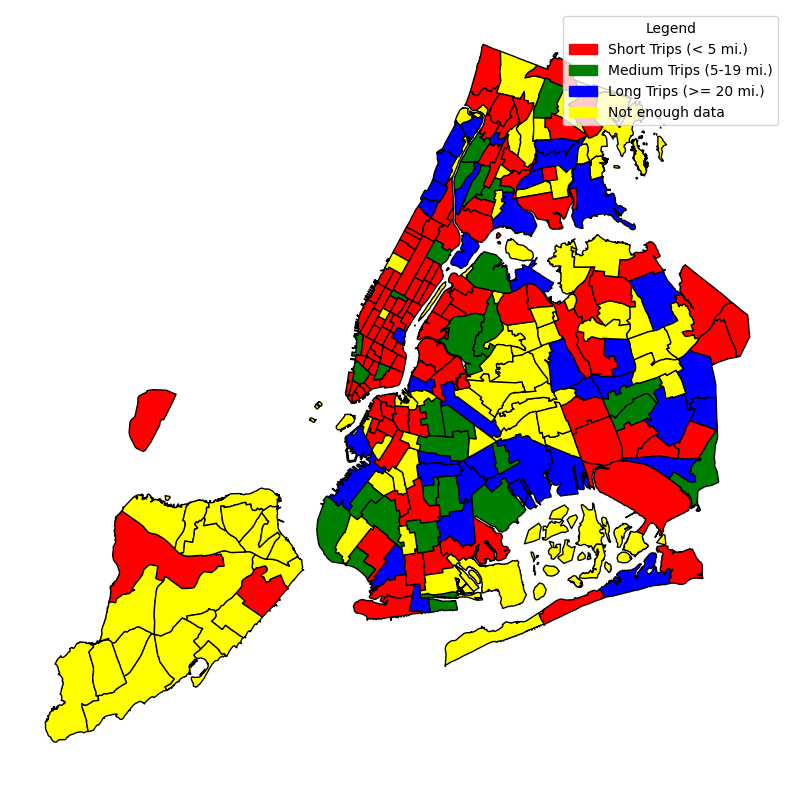

In [263]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load the shapefile
gdf = gpd.read_file('./taxi_zones/taxi_zones.shp')

# Merge with the color mapping dataframe
color_mapping_df = res_df[['region_id', 'color']]
gdf = gdf.merge(color_mapping_df, how='left', left_on='LocationID', right_on='region_id')
gdf['color'] = gdf['color'].fillna('yellow')

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black')

# Add legend
legend_handles = [
    Patch(color='red', label=f'Short Trips (< 5 mi.)'),
    Patch(color='green', label=f'Medium Trips (5-19 mi.)'),
    Patch(color='blue', label=f'Long Trips (>= 20 mi.)'),
    Patch(color='yellow', label=f'Not enough data')
]

ax.legend(handles=legend_handles, title='Legend', loc='upper right')

# Set title and hide axis
# ax.set_title("Most Profitable Trips in New York, based on Average Tip Rate (Percent)", fontsize=15)
ax.set_axis_off()  # Hide the axis

# Show the plot
plt.show()

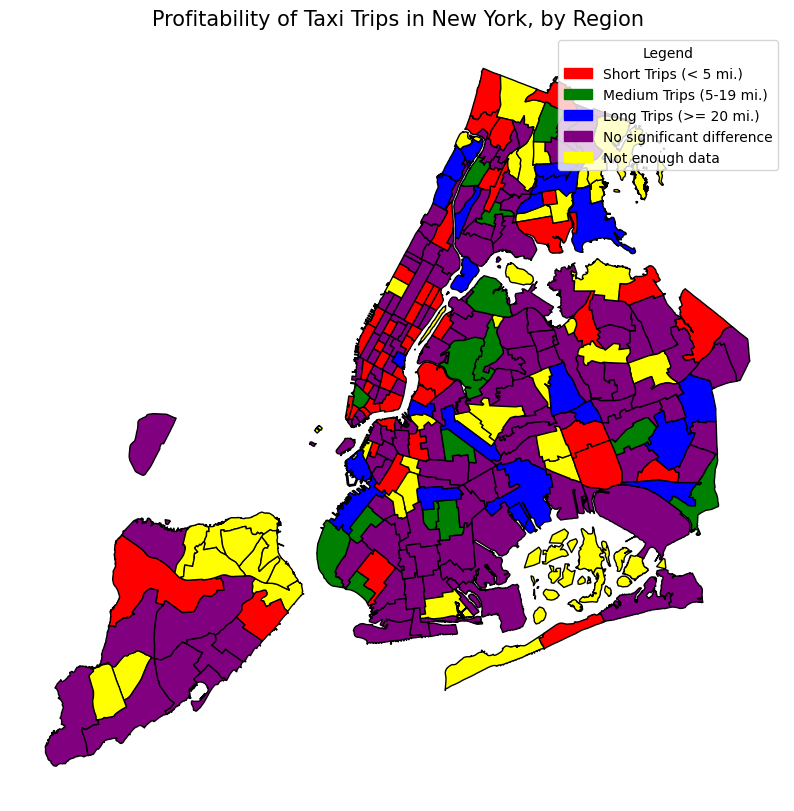

In [264]:
gdf['is_statistically_significant'] = res_df['is_statistically_significant']
gdf.loc[gdf['is_statistically_significant'] == False, 'color'] = 'purple'

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black')

legend_handles = [
    Patch(color='red', label=f'Short Trips (< 5 mi.)'),
    Patch(color='green', label=f'Medium Trips (5-19 mi.)'),
    Patch(color='blue', label=f'Long Trips (>= 20 mi.)'),
    Patch(color='purple', label=f'No significant difference'),
    Patch(color='yellow', label=f'Not enough data')
]

ax.legend(handles=legend_handles, title='Legend', loc='upper right')



ax.set_title("Profitability of Taxi Trips in New York, by Region", fontsize=15)
ax.set_axis_off()  # Hide the axis

# Show the plot
plt.show()

### Now analyze based on drop-off regions.

In [265]:
other_regions = []

def do_percent_analyze_region(reg_id:int, bins = [0, 5, 20, float('inf')], min_entries=15, verbose=False)->int:
    """
        Given the ID of a region (and optionally the bins for the trip distances), 
        perform the above analysis and return what length of trip gives the best tips 
        as well as its H-value and its significance.
    """

    if verbose: print(f"Examining region {reg_id}")
    df_region = df[df['DOLocationID'] == reg_id][['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount']]
    df_region['tip_percent'] = df_region['tip_amount'] / df_region['fare_amount']
    
    if verbose: 
        print(df_region.info())
        print("----------------------------")

        print(f"Number of missing values in relevant columns for region {reg_id}:")
        print(df_region[['tip_percent', 'trip_distance', 'PULocationID', 'DOLocationID']].isna().sum())
        print(df_region[['tip_percent', 'trip_distance', 'PULocationID', 'DOLocationID']].isnull().sum())
        print("----------------------------")
    
    q1, q3 = df_region['tip_percent'].describe()['25%'], df_region['tip_percent'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['tip_percent'] < q1 - 1.5*iqr) | (df_region['tip_percent'] > q3 + 1.5*iqr)])
    
    if verbose: 
        print(f"Found {outliers} outliers in 'tip_amount' - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['tip_amount'])
        plt.title(f'Boxplot for tipping amount in region {reg_id}')
        plt.show()
        print("----------------------------")

    q1, q3 = df_region['trip_distance'].describe()['25%'], df_region['trip_distance'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['trip_distance'] < q1 - 1.5*iqr) | (df_region['trip_distance'] > q3 + 1.5*iqr)])

    if verbose: 
        print(f"Found {outliers} outliers in 'trip_distance' for {reg_id} - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['trip_distance'])
        plt.title(f"Box Plot of Trip Distances in region {reg_id}")
        plt.show()

        plt.title(f"Box Plot of Trip Distances, limited range, in region {reg_id}")
        sns.boxplot(x=df_region['trip_distance'])
        plt.xlim(left=0, right=200)
        plt.show()
        print("----------------------------")

        sns.scatterplot(data=df_region, x='trip_distance', y='tip_percent')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in region {reg_id}")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.show()

        # Remove outliers
        sns.scatterplot(data=df_region, x='trip_distance', y='tip_percent')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in region {reg_id}, without outliers")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.xlim(left=0, right=200)
        plt.ylim(bottom=0)
        plt.show()    
        print("----------------------------")

    labels = ['short', 'medium', 'long']
    df_region['trip_bin'] = pd.cut(df_region['trip_distance'], bins=bins, labels=labels)

    for bin in ['short', 'medium', 'long']:
        if verbose: print("For bin", bin, ":")
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_percent']
        if verbose: print(f"Mean tip: {tip_bin.mean()}, median tip: {tip_bin.median()}, mode tip: {tip_bin.mode()[0]}")
        # print(f"Median tip, discarding zeros: {tip_bin[tip_bin > 0].median()}, mode tip, discarding zeros: {tip_bin[tip_bin > 0].mode()[0]}")
        
        if len(tip_bin) >= min_entries:
            skew_val = skew(tip_bin)
            if verbose: print("Skew:", skew_val)
            if skew_val < -1 or skew_val > 1:
                if verbose: print("Values are too skewed.")

        if verbose: 
            sns.histplot(data=tip_bin)
            plt.xlim(left=0)
            plt.show()

    if verbose: 
        print(f"Value count of each trip type in each region:\n{df_region['trip_bin'].value_counts()}")

        print("----------------------------")

    max_tip, max_bin = None, None
    tips = []

    for bin in ['short', 'medium', 'long']:
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_percent']
        expected_tip = tip_bin.mean() 
        tips.append(expected_tip)
        if verbose: print(f"Expected average tip percent for {bin} trips: {expected_tip:.2f}")
        if not max_tip or expected_tip > max_tip:
            max_bin = bin
            max_tip = expected_tip

    print(f"For region {reg_id}, the taxi company should prioritize {max_bin} trips, for an average expected tip percent of ${max_tip:.2f}.")
    print("----------------------------")

    # Check if we have 30 points to sample.
    # If not, sample as much as we can.
    result = None

    try:
        bottleneck = min([len(df_region[df_region['trip_bin'] == bin]) for bin in ['short', 'medium', 'long']])
        if bottleneck >= min_entries:
            sample_number = min(bottleneck, 30)
            print(f"Sampling {sample_number} entries.")
            samples = [df_region[df_region['trip_bin'] == bin]['tip_percent'].sample(n=sample_number, random_state=42).to_list() for bin in ['short', 'medium', 'long']]
            
            result = kruskal(*samples)
            print(result)
            if verbose: print(result.statistic, result.pvalue)

            if result.pvalue < 0.05:
                print("Reject the null hypothesis - there is significant difference between the groups.")
                if result.statistic > 5.991:
                    print("Results are statistically significant.")
            else:
                print("Failed to reject null hypothesis.")
            print("----------------------------")

        else:
            print(f"Could not run hypothesis test on region {reg_id}")
            other_regions.append(reg_id)
    except ValueError:
        print(f"Could not run hypothesis test on region {reg_id}")
        other_regions.append(reg_id)

    return {
        'region_id':reg_id,
        'short_tip_percent':tips[0],
        'med_tip_percent':tips[1],
        'long_tip_percent':tips[2],
        'max_tip_percent':max_tip,
        'max_bin':max_bin,
        'is_statistically_significant':result.pvalue < 0.05 if result else None,
        'has_rejected_null_hyp':result.statistic > 5.991 if result else None
    }

In [266]:
lookup = pd.read_csv("taxi_zone_lookup.csv")
lookup = lookup.rename(columns={'LocationID':'DOLocationID'})
lookup.head()

,DOLocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [267]:
df = pd.read_parquet("tripdata_combined.parquet")
df = pd.merge(df, lookup, on='DOLocationID' ,how="inner")
print(df.head().to_markdown())

|    |   VendorID | tpep_pickup_datetime   | tpep_dropoff_datetime   |   passenger_count |   trip_distance |   RatecodeID | store_and_fwd_flag   |   PULocationID |   DOLocationID |   payment_type |   fare_amount |   extra |   mta_tax |   tip_amount |   tolls_amount |   improvement_surcharge |   total_amount |   congestion_surcharge |   airport_fee |   Airport_fee | Borough   | Zone                  | service_zone   |
|---:|-----------:|:-----------------------|:------------------------|------------------:|----------------:|-------------:|:---------------------|---------------:|---------------:|---------------:|--------------:|--------:|----------:|-------------:|---------------:|------------------------:|---------------:|-----------------------:|--------------:|--------------:|:----------|:----------------------|:---------------|
|  0 |          2 | 2023-01-29 17:52:02    | 2023-01-29 17:56:43     |                 1 |            1.17 |            1 | N                    |            

In [268]:
locations = df['DOLocationID'].unique()
results = []
for id in locations:
    # results.append(analyze_region(id, min_entries=1))
    results.append(percent_analyze_region(id))

For region 74, the taxi company should prioritize short trips, for an average expected tip percent of $0.10.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.021262022669806), pvalue=np.float64(0.6001167788215893))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 237, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.5218248378361976), pvalue=np.float64(0.7703483846056722))
Failed to reject null hypothesis.
----------------------------
For region 261, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Sampling 30 entries.
KruskalResult(statistic=np.float64(7.396952160816959), pvalue=np.float64(0.024761231859392534))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 141, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.0649005901804454), pvalue=np.float64(0.587164479344986))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 140, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(8.664496392690577), pvalue=np.float64(0.01313797750995161))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 262, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.6374592252163422), pvalue=np.float64(0.26747488293940347))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 231, the taxi company should prioritize medium trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 162, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(11.22464720885679), pvalue=np.float64(0.0036525723564167015))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 87, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.061224125325808), pvalue=np.float64(0.35678851679564444))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 263, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(7.890282968812723), pvalue=np.float64(0.019348478667992778))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 79, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.7496157156997336), pvalue=np.float64(0.15338443562899878))
Failed to reject null hypothesis.
----------------------------
For region 235, the taxi company should prioritize medium trips, for an average expected tip percent of $0.01.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.1358413481999), pvalue=np.float64(0.046517779989792715))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 62, the taxi company should prioritize long trips, for an average expected tip percent of $0.04.
----------------------------
Sampling 27 entries.
KruskalResult(statistic=np.float64(0.4045605068849251), pvalue=np.float64(0.8168659663609964))
Failed to reject null hypo

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 246, the taxi company should prioritize short trips, for an average expected tip percent of $0.20.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(14.42575822573638), pvalue=np.float64(0.0007370320991912738))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 144, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(20.12571784000611), pvalue=np.float64(4.2633982134235264e-05))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 152, the taxi company should prioritize long trips, for an average expected tip percent of $0.11.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(5.395427903751364), pvalue=np.float64(0.06735932351852862))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 163, the taxi company should prioritize medium trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.42625681953338335), pvalue=np.float64(0.8080523687380436))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 48, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(7.1967480519480524), pvalue=np.float64(0.02736818624898201))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 161, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(22.020634907375715), pvalue=np.float64(1.6530267663257836e-05))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 170, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.6218364737924635), pvalue=np.float64(0.16350393250818732))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 234, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(5.02265178260648), pvalue=np.float64(0.08116055779197612))
Failed to reject null hypothesis.
----------------------------
For region 75, the taxi company should prioritize medium trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(10.742323358701034), pvalue=np.float64(0.004648727841202413))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 236, the taxi company should prioritize short trips, for an average expected tip percent of $0.22.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1127: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


For region 137, the taxi company should prioritize long trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(12.432059095106208), pvalue=np.float64(0.0019971591212987927))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


For region 239, the taxi company should prioritize short trips, for an average expected tip percent of $nan.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.619230769230805), pvalue=np.float64(0.44502919838709476))
Failed to reject null hypothesis.
----------------------------
For region 36, the taxi company should prioritize long trips, for an average expected tip percent of $0.08.
----------------------------
Could not run hypothesis test on region 36
For region 166, the taxi company should prioritize short trips, for an average expected tip percent of $0.17.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.8855319065996414), pvalue=np.float64(0.1433070205605158))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 264, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(8.865285360566872), pvalue=np.float64(0.011883045053182417))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 232, the taxi company should prioritize short trips, for an average expected tip percent of $0.15.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.30216497582911983), pvalue=np.float64(0.8597767745409355))
Failed to reject null hypothesis.
----------------------------
For region 145, the taxi company should prioritize short trips, for an average expected tip percent of $0.13.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.6402112994918814), pvalue=np.float64(0.44038512547152997))
Failed to reject null

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 132, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.920848679277967), pvalue=np.float64(0.031416427953785665))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


For region 100, the taxi company should prioritize short trips, for an average expected tip percent of $nan.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(15.768718699126348), pvalue=np.float64(0.0003765877954120161))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 164, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(5.081827454053786), pvalue=np.float64(0.07879437034231074))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 233, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(9.241800603691198), pvalue=np.float64(0.009843929562570485))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 230, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.2644890695772557), pvalue=np.float64(0.19549029655297978))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 238, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(7.808158113715463), pvalue=np.float64(0.02015951170896563))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 209, the taxi company should prioritize short trips, for an average expected tip percent of $0.18.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.553693586830623), pvalue=np.float64(0.037747093734538446))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 42, the taxi company should prioritize short trips, for an average expected tip percent of $0.06.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float6

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 113, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(17.97302991328877), pvalue=np.float64(0.00012508526206746293))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 88, the taxi company should prioritize short trips, for an average expected tip percent of $0.17.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.0250315572917534), pvalue=np.float64(0.3633038368711984))
Failed to reject null hypothesis.
----------------------------
For region 142, the taxi company should prioritize short trips, for an average expected tip percent of $0.22.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.3573964497041429), pvalue=np.float64(0.5072769232233703))
Failed to reject null 

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 114, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(10.87011522542941), pvalue=np.float64(0.004360983765801282))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 12, the taxi company should prioritize short trips, for an average expected tip percent of $0.16.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.2670179224568983), pvalue=np.float64(0.5307262320453509))
Failed to reject null hypothesis.
----------------------------
For region 151, the taxi company should prioritize short trips, for an average expected tip percent of $0.19.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.7960385930165448), pvalue=np.float64(0.40737575173635576))
Failed to reject null 

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 80, the taxi company should prioritize short trips, for an average expected tip percent of $0.11.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.065900383141762), pvalue=np.float64(0.3559552737449235))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 68, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(10.854893798137686), pvalue=np.float64(0.004394300586028966))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 41, the taxi company should prioritize short trips, for an average expected tip percent of $0.11.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.3069596323213504), pvalue=np.float64(0.3155368465065224))
Failed to reject null hypothesis.
----------------------------
For region 61, the taxi company should prioritize medium trips, for an average expected tip percent of $0.03.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.060051569607684), pvalue=np.float64(0.3569977553333769))
Failed to reject null hyp

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 90, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.6400389445635661), pvalue=np.float64(0.7261348974326904))
Failed to reject null hypothesis.
----------------------------
For region 229, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(16.845797175923252), pvalue=np.float64(0.00021977668661815123))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 258, the taxi company should prioritize long trips, for an average expected tip percent of $0.04.
----------------------------
Could not run hypothesis test on region 258
For region 260, the taxi company should prioritize medium trips, for an average expected tip p

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 148, the taxi company should prioritize medium trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(17.476341962474113), pvalue=np.float64(0.00016034689735181174))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 56, the taxi company should prioritize medium trips, for an average expected tip percent of $0.06.
----------------------------
Could not run hypothesis test on region 56
For region 24, the taxi company should prioritize short trips, for an average expected tip percent of $0.18.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.233509962971944), pvalue=np.float64(0.19854192710502191))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documen

For region 211, the taxi company should prioritize short trips, for an average expected tip percent of $0.20.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.3781239122383315), pvalue=np.float64(0.041210510080436386))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 50, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.112249043661783), pvalue=np.float64(0.04706976002542856))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 1, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 107, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.6697384392497607), pvalue=np.float64(0.15963437744678818))
Failed to reject null hypothesis.
----------------------------
For region 126, the taxi company should prioritize long trips, for an average expected tip percent of $0.01.
----------------------------
Sampling 28 entries.
KruskalResult(statistic=np.float64(0.4261718414035903), pvalue=np.float64(0.8080867028569859))
Failed to reject null hypothesis.
----------------------------
For region 125, the taxi company should prioritize short trips, for an average expected tip percent of $0.21.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(5.436917800363146), pvalue=np.float64(0.06597635226458559))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1127: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 66, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.025245164628946153), pvalue=np.float64(0.9874567483409528))
Failed to reject null hypothesis.
----------------------------
For region 143, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.1896249207857967), pvalue=np.float64(0.20294658545673855))
Failed to reject null hypothesis.
----------------------------
For region 255, the taxi company should prioritize short trips, for an average expected tip percent of $0.11.
----------------------------
Sampling 29 entries.
KruskalResult(statistic=np.float64(0.6669420292046865), pvalue=np.float64(0.7164326644246835))
Failed to reject null hypothesis.
----------------------------


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 138, the taxi company should prioritize long trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(6.506184179536348), pvalue=np.float64(0.03865449966998518))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 186, the taxi company should prioritize short trips, for an average expected tip percent of $0.20.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Failed to reject null hypothesis.
----------------------------
For region 33, the taxi company should prioritize short trips, for an average expected tip percent of $0.17.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.7986058981233417), pvalue=np.float64(0.14967291251365414))
Failed to reject null hypothesis.
---------------------

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 249, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.331025320939997), pvalue=np.float64(0.18909369226770975))
Failed to reject null hypothesis.
----------------------------
For region 202, the taxi company should prioritize long trips, for an average expected tip percent of $0.12.
----------------------------
Could not run hypothesis test on region 202
For region 7, the taxi company should prioritize short trips, for an average expected tip percent of $0.08.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.507345564652695), pvalue=np.float64(0.7759456636451487))
Failed to reject null hypothesis.
----------------------------
For region 25, the taxi company should prioritize short trips, for an average expected tip percent of $0.13.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 40, the taxi company should prioritize short trips, for an average expected tip percent of $0.14.
----------------------------
Sampling 29 entries.
KruskalResult(statistic=np.float64(1.5686211770083656), pvalue=np.float64(0.4564342643705911))
Failed to reject null hypothesis.
----------------------------
For region 157, the taxi company should prioritize short trips, for an average expected tip percent of $0.18.
----------------------------
Could not run hypothesis test on region 157
For region 26, the taxi company should prioritize medium trips, for an average expected tip percent of $0.01.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.0116104868916602), pvalue=np.float64(0.6030198021270377))
Failed to reject null hypothesis.
----------------------------
For region 116, the taxi company should prioritize long trips, for an average expected tip percent of $0.13.
----------------------------
Sampling 30 entries.
KruskalResult(statistic

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 196, the taxi company should prioritize long trips, for an average expected tip percent of $0.10.
----------------------------
Could not run hypothesis test on region 196
For region 65, the taxi company should prioritize short trips, for an average expected tip percent of $0.13.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.5802239905687565), pvalue=np.float64(0.2752399557864077))
Failed to reject null hypothesis.
----------------------------
For region 53, the taxi company should prioritize long trips, for an average expected tip percent of $0.12.
----------------------------
Could not run hypothesis test on region 53
For region 89, the taxi company should prioritize short trips, for an average expected tip percent of $0.03.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(4.231565045124503), pvalue=np.float64(0.12053892820708059))
Failed to reject null hypothesis.
----------------------------
For 

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documen

For region 10, the taxi company should prioritize short trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(12.511961173404803), pvalue=np.float64(0.0019189433428491568))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 228, the taxi company should prioritize long trips, for an average expected tip percent of $0.07.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.7639383315354), pvalue=np.float64(0.15228992619279694))
Failed to reject null hypothesis.
----------------------------
For region 189, the taxi company should prioritize long trips, for an average expected tip percent of $0.12.
----------------------------
Could not run hypothesis test on region 189
For region 127, the taxi company should prioritize long trips, for an average expected tip percent

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 257, the taxi company should prioritize long trips, for an average expected tip percent of $0.12.
----------------------------
Could not run hypothesis test on region 257
For region 222, the taxi company should prioritize long trips, for an average expected tip percent of $0.01.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(2.0008397877829247), pvalue=np.float64(0.36772500326733515))
Failed to reject null hypothesis.
----------------------------
For region 223, the taxi company should prioritize medium trips, for an average expected tip percent of $inf.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(3.6692701163761283), pvalue=np.float64(0.1596717620388205))
Failed to reject null hypothesis.
----------------------------
For region 252, the taxi company should prioritize long trips, for an average expected tip percent of $0.07.
----------------------------
Could not run hypothesis test on region 252


c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 197, the taxi company should prioritize short trips, for an average expected tip percent of $0.07.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(9.779702479338804), pvalue=np.float64(0.007522541447514515))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 192, the taxi company should prioritize long trips, for an average expected tip percent of $0.07.
----------------------------
Could not run hypothesis test on region 192
For region 193, the taxi company should prioritize short trips, for an average expected tip percent of $0.09.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(10.586567450126768), pvalue=np.float64(0.005025231657707074))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For reg

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


For region 208, the taxi company should prioritize long trips, for an average expected tip percent of $0.05.
----------------------------
Sampling 20 entries.
KruskalResult(statistic=np.float64(3.5699571381470943), pvalue=np.float64(0.16780065708519273))
Failed to reject null hypothesis.
----------------------------
For region 92, the taxi company should prioritize short trips, for an average expected tip percent of $0.07.
----------------------------
Sampling 20 entries.
KruskalResult(statistic=np.float64(4.384434845212366), pvalue=np.float64(0.11166885683093274))
Failed to reject null hypothesis.
----------------------------
For region 218, the taxi company should prioritize short trips, for an average expected tip percent of $0.01.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.448137895011868), pvalue=np.float64(0.7992600254842269))
Failed to reject null hypothesis.
----------------------------
For region 46, the taxi company should prioritiz

c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Py Torch\Documents\GitHub\CabBoost\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1127: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


For region 73, the taxi company should prioritize medium trips, for an average expected tip percent of $0.02.
----------------------------
Could not run hypothesis test on region 73
For region 194, the taxi company should prioritize long trips, for an average expected tip percent of $0.18.
----------------------------
Sampling 17 entries.
KruskalResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Failed to reject null hypothesis.
----------------------------
For region 117, the taxi company should prioritize long trips, for an average expected tip percent of $0.01.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(1.0116104868916602), pvalue=np.float64(0.6030198021270377))
Failed to reject null hypothesis.
----------------------------
For region 245, the taxi company should prioritize short trips, for an average expected tip percent of $3.02.
----------------------------
Could not run hypothesis test on region 245
For region 173, the taxi compan

In [269]:
results_df = pd.DataFrame(results)

results_df = pd.merge(
    results_df, 
    lookup, 
    left_on='region_id', 
    right_on='DOLocationID',
    how='left'    
)
print(results_df.isna().sum())
print(len(results_df))

region_id                        0
short_tip_percent                3
med_tip_percent                  2
long_tip_percent                 3
max_tip_percent                  3
max_bin                          0
is_statistically_significant    79
has_rejected_null_hyp           79
DOLocationID                     0
Borough                          1
Zone                             1
service_zone                     2
dtype: int64
262


In [270]:
res_df = results_df.dropna()
print(len(res_df))

res_df.to_csv("pu_percent_analysis_data.csv", index=False)

179


In [271]:
res_df = pd.read_csv('pu_percent_analysis_data.csv')
res_df['color'] = res_df['max_bin'].map({
    'short':'red',
    'medium':'green',
    'long':'blue',
})
res_df.head()

,region_id,short_tip_percent,med_tip_percent,long_tip_percent,max_tip_percent,max_bin,is_statistically_significant,has_rejected_null_hyp,DOLocationID,Borough,Zone,service_zone,color
0,74,0.098891,0.069567,0.070837,0.098891,short,False,False,74,Manhattan,East Harlem North,Boro Zone,red
1,237,inf,0.264058,0.168636,inf,short,False,False,237,Manhattan,Upper East Side South,Yellow Zone,red
2,261,inf,0.152048,0.151374,inf,short,True,True,261,Manhattan,World Trade Center,Yellow Zone,red
3,141,inf,0.158216,0.158710,inf,short,False,False,141,Manhattan,Lenox Hill West,Yellow Zone,red
4,140,inf,0.147998,0.135940,inf,short,True,True,140,Manhattan,Lenox Hill East,Yellow Zone,red


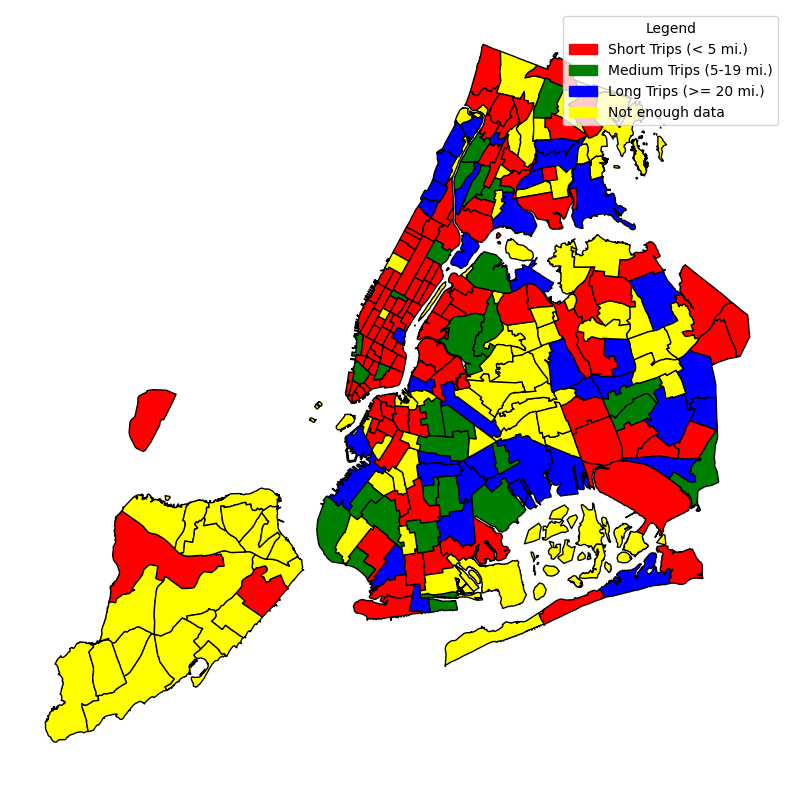

In [272]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load the shapefile
gdf = gpd.read_file('./taxi_zones/taxi_zones.shp')

# Merge with the color mapping dataframe
color_mapping_df = res_df[['region_id', 'color']]
gdf = gdf.merge(color_mapping_df, how='left', left_on='LocationID', right_on='region_id')
gdf['color'] = gdf['color'].fillna('yellow')

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black')

# Add legend
legend_handles = [
    Patch(color='red', label=f'Short Trips (< 5 mi.)'),
    Patch(color='green', label=f'Medium Trips (5-19 mi.)'),
    Patch(color='blue', label=f'Long Trips (>= 20 mi.)'),
    Patch(color='yellow', label=f'Not enough data')
]

ax.legend(handles=legend_handles, title='Legend', loc='upper right')

# Set title and hide axis
# ax.set_title("Most Profitable Trips in New York, based on Average Tip Rate (Percent)", fontsize=15)
ax.set_axis_off()  # Hide the axis

# Show the plot
plt.show()

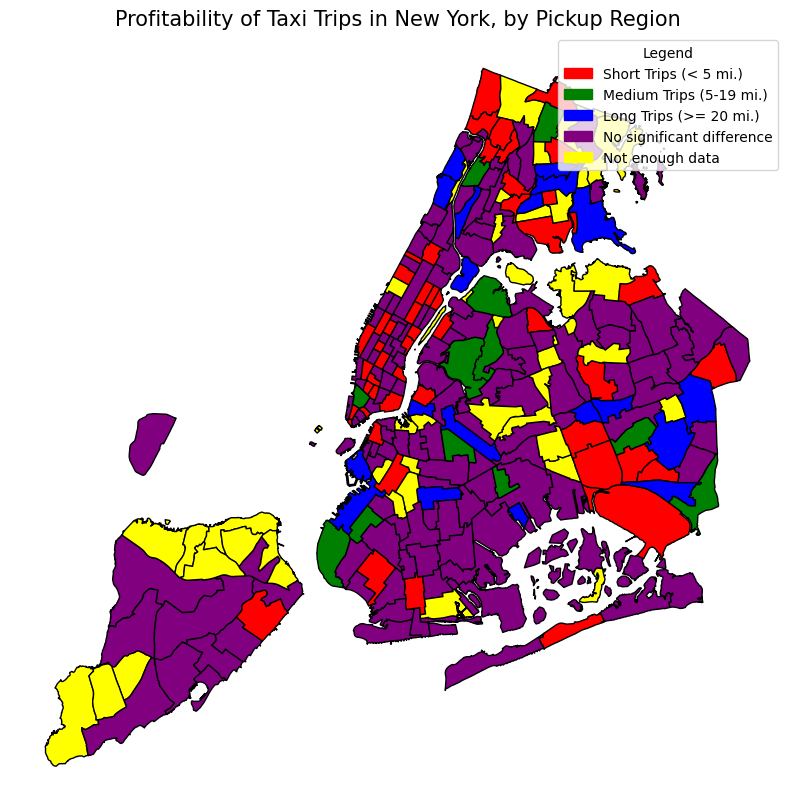

In [273]:
gdf['is_statistically_significant'] = res_df['is_statistically_significant']
gdf.loc[gdf['is_statistically_significant'] == False, 'color'] = 'purple'

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black')

legend_handles = [
    Patch(color='red', label=f'Short Trips (< 5 mi.)'),
    Patch(color='green', label=f'Medium Trips (5-19 mi.)'),
    Patch(color='blue', label=f'Long Trips (>= 20 mi.)'),
    Patch(color='purple', label=f'No significant difference'),
    Patch(color='yellow', label=f'Not enough data')
]

ax.legend(handles=legend_handles, title='Legend', loc='upper right')

ax.set_title("Profitability of Taxi Trips in New York, by Pickup Region", fontsize=15)
ax.set_axis_off()  # Hide the axis

# Show the plot
plt.show()